In [73]:
from __future__ import print_function, division
import pylab as pl
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import preprocessing
import statsmodels.api as sm

%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Read in Data

In [2]:
## come back to download section - but for now you need to have the file at this URL saved in the same directory where you're executing this notebook.
url = 'https://github.com/fedhere/PUI2018_fb55/raw/master/HW11_fb55/MTA_Fare2.npy'

In [3]:
mta = np.load("MTA_Fare2.npy")

In [4]:
print ("MTA array shape:", mta.shape)
print ("MTA array shape summed over all ride types:", np.nansum(mta,axis=1).shape)

MTA array shape: (600, 23, 194)
MTA array shape summed over all ride types: (600, 194)


In [5]:
#ridership type list
card_types = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])
print("number of ride types", len(card_types))

number of ride types 23


In [6]:
mta = mta.astype(float)
mta[mta == -1] = np.nan
len(mta[mta == -1])

0

In [7]:
#This is the information I recieved about the data: 
#"each time series (per station, per ticket type) contains the number of swipes per week 
#for 194 weeks from 05/19/2010 to 02/19/2014

weeks = pd.date_range(start='05/19/2010', periods=194, freq='W')
weeks

DatetimeIndex(['2010-05-23', '2010-05-30', '2010-06-06', '2010-06-13',
               '2010-06-20', '2010-06-27', '2010-07-04', '2010-07-11',
               '2010-07-18', '2010-07-25',
               ...
               '2013-12-01', '2013-12-08', '2013-12-15', '2013-12-22',
               '2013-12-29', '2014-01-05', '2014-01-12', '2014-01-19',
               '2014-01-26', '2014-02-02'],
              dtype='datetime64[ns]', length=194, freq='W-SUN')

In [8]:
np.size(mta)

2677200

In [9]:
#stations
np.size(mta,0)

600

In [10]:
#card types
np.size(mta,1)

23

In [11]:
#weeks of data
np.size(mta,2)

194

### Make a plot of the data

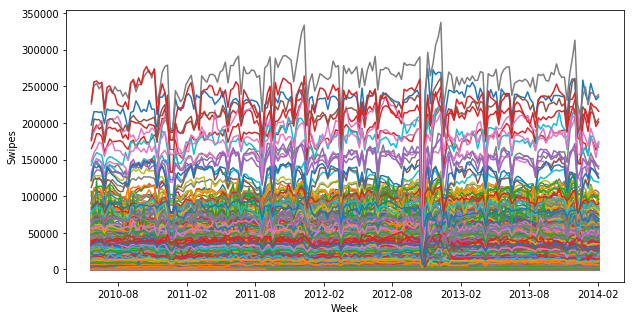

In [12]:
fig, ax = plt.subplots(figsize=(10,5))

ax.set_ylabel("Swipes")
ax.set_xlabel("Week")

for station in range(np.size(mta,0)):
    for card_type in range(np.size(mta,1)):
        ax.plot(weeks, mta[station][card_type])
    

Figure showing the number of swipes by card type (color) and week (x-axis) over 600 MTA Subway Stations.

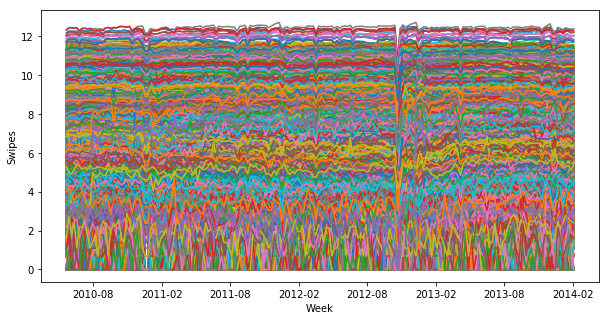

In [13]:
fig, ax = plt.subplots(figsize=(10,5))

ax.set_ylabel("Swipes")
ax.set_xlabel("Week")

for station in range(np.size(mta,0)):
    for card_type in range(np.size(mta,1)):
        ax.plot(weeks, np.log(mta[station][card_type]))

Figure showing the number of swipes in log space by card type (color) and week (x-axis) over 600 MTA Subway Stations.

### Event Detection

In [14]:
# mta[station][card_type][weeks]

In [15]:
#sum along card axis so we have total rides per station per week for all card types
card_sum = np.nansum(mta, axis=1)
print("Mean swipes per week per station for all card types:",np.nanmean(card_sum))
print("Standard deviation swipes per week per station for all card types:", np.nanstd(card_sum))
swipe_mean = np.nanmean(card_sum)
swipe_std = np.nanstd(card_sum)
thresholds = swipe_mean + (3 * swipe_std), swipe_mean - (3 * swipe_std)
print("Three Sigma thresholds:", thresholds)

Mean swipes per week per station for all card types: 49635.5831186
Standard deviation swipes per week per station for all card types: 69320.3333425
Three Sigma thresholds: (257596.58314608919, -158325.41690897578)


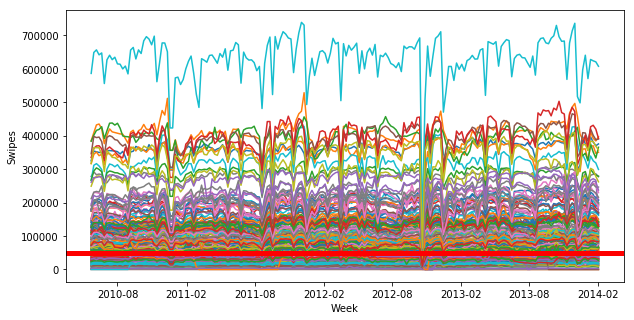

In [16]:
fig, ax = plt.subplots(figsize=(10,5))

ax.set_ylabel("Swipes")
ax.set_xlabel("Week")

for station in range(len(card_sum[0,])):
    ax.plot(weeks, card_sum[station,])
    
plt.axhline(y=swipe_mean, color='r', linestyle='-', lw='5')
#plt.axhline(y=thresholds[0], color='g', linestyle='-', lw='5')
#plt.axhline(y=thresholds[1], color='g', linestyle='-', lw='5')

Figure showing the total swipes per week for all stations and a line representing the average swipes across all stations.

In [17]:
#sum along card axis and station axis so we have total rides per week for all card types
all_mean = np.nanmean(np.nansum(card_sum, axis=0))
all_std = np.nanstd(np.nansum(card_sum, axis=0))
all_thresholds = all_mean + 3 * all_std, all_mean - 3 * all_std

print("Mean swipes per week per station for all card types:", all_mean)
print("Standard deviation swipes per week per station for all card types:", all_std)
print("Three Sigma thresholds:", all_thresholds)

Mean swipes per week per station for all card types: 29781349.8711
Standard deviation swipes per week per station for all card types: 2983960.4217
Three Sigma thresholds: (38733231.136236683, 20829468.606031362)


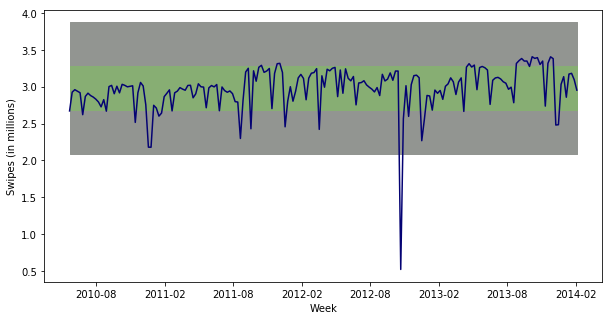

In [18]:
fig, ax = plt.subplots(figsize=(10,5))

ax.set_ylabel("Swipes (in millions)")
ax.set_xlabel("Week")


plt.fill_between(weeks, (all_mean + 3 * all_std) / 1e7, (all_mean - 3 * all_std) / 1e7, color ='xkcd:grey')
plt.fill_between(weeks, (all_mean + all_std) / 1e7, (all_mean - all_std) / 1e7, color ='xkcd:sage')
ax.plot(weeks, np.nansum(card_sum, axis=0) / 1e7, color = 'xkcd:deep blue')


Figure showing the total number of swipes in the millions at all stations over the course of 194 weeks.

In [19]:
#find date corresponding with lowest week
np.argmin(np.nansum(card_sum, axis=0))

126

In [20]:
weeks[126]

Timestamp('2012-10-21 00:00:00', offset='W-SUN')

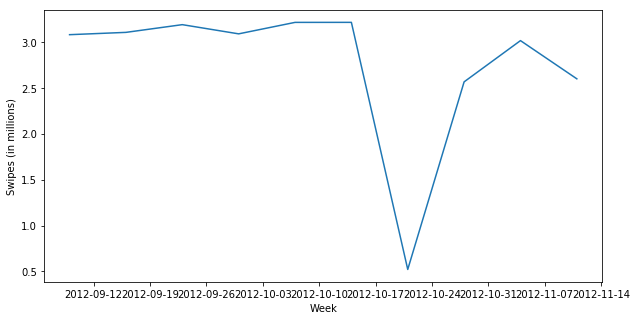

In [21]:
fig, ax = plt.subplots(figsize=(10,5))

ax.set_ylabel("Swipes (in millions)")
ax.set_xlabel("Week")


ax.plot(weeks[120:130], (np.nansum(card_sum, axis=0) / 1e7)[120:130])

Figure showing a zoomed in section of the minimum, which corresponds to the period of Superstorm Sandy in New York City.

### Find trends

In [22]:
#sum over all stations to make 23 time series
card_names_and_sums = {}

for i in range(len(card_types)):
    card_type_sums = np.nansum(mta, axis=0)[i]
    card_names_and_sums[card_types[i]] = card_type_sums

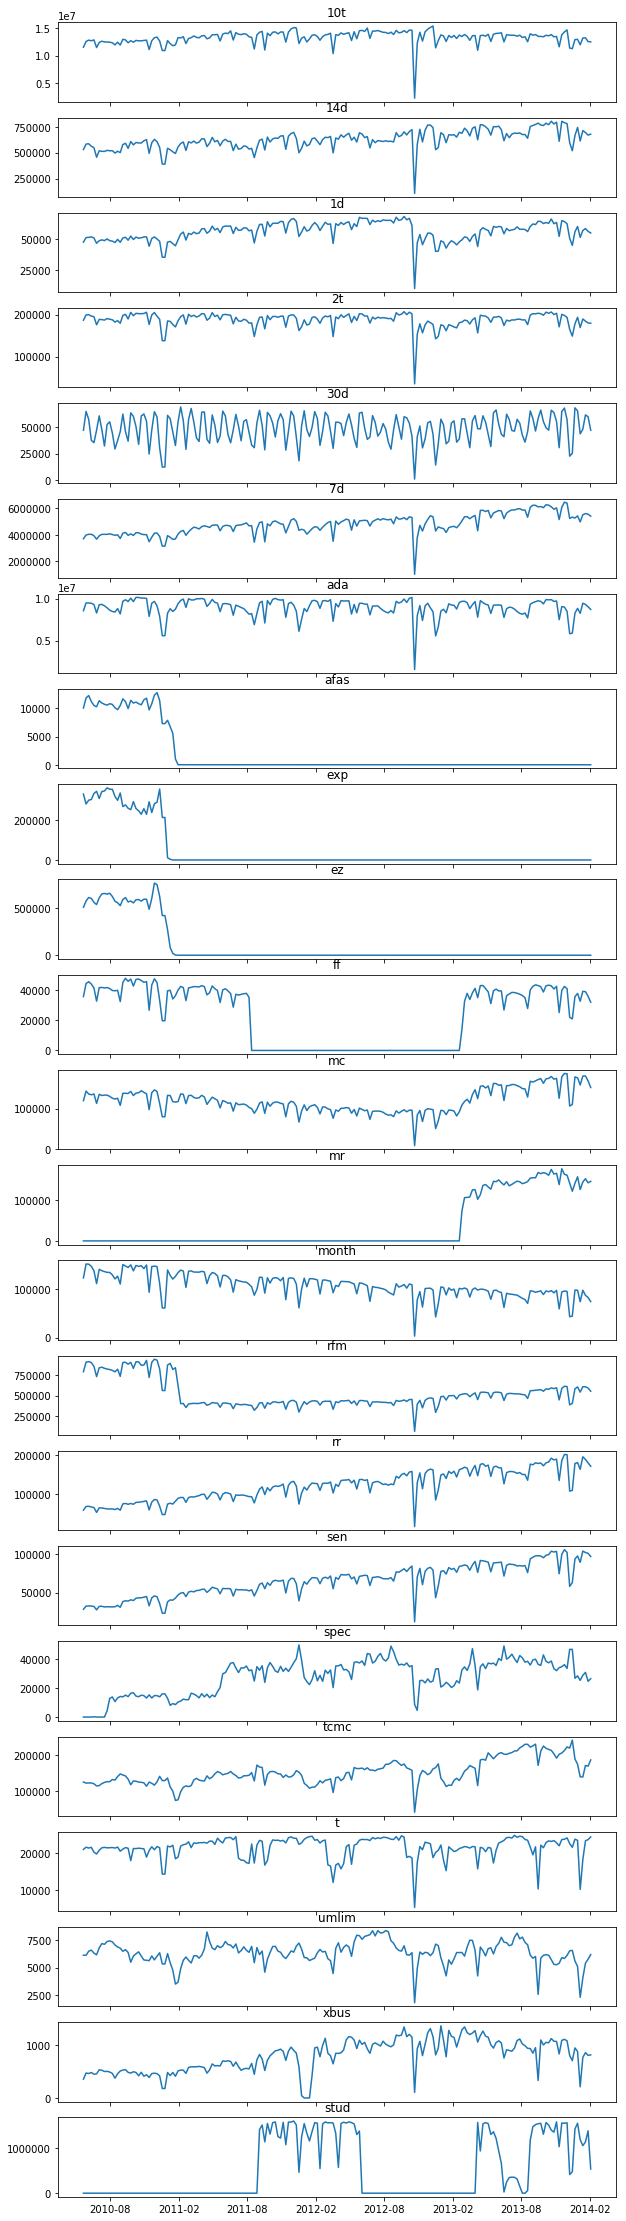

In [23]:
#make a bunch of plots
fig, ax_array = plt.subplots(nrows=23, sharex=True, figsize = (10,40))
    
for i in range(len(ax_array)):
    key = card_types[i]
    value_array = card_names_and_sums[key]
    ax_array[i].set_title(key)
    ax_array[i].plot(weeks, value_array)

Figure showing for each different kind of metrocard, the total number of times that kind of card was swiped per week over a 194 week period from 05/19/2010 to 02/19/2014.

Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the ridership types that have steadily increased in popularity, and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)

By eye, it looks like there are a few card types with trends going on.  Monthly metrocard usage appears to be declining, while railroad and senior citizen/disabled passes appear to be increasing.

In [24]:
#calculate rolling averages for those card types

trending_cards = ['sen','rr','month']
rolling_means = {}

for i in range(len(trending_cards)):
    key = trending_cards[i]
    value_array = card_names_and_sums[key]
    rolling_mean = pd.rolling_mean(card_names_and_sums[key], window=5)
    rolling_means[key] = rolling_mean
    

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:9: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version


In [25]:
for key, value in rolling_means.iteritems():
    print("Card Type:", key) 
    print("Ratio of Rides at the Beginning to Rides at the End:", (rolling_means[key][193] / rolling_means[key][4]))

Card Type: sen
Ratio of Rides at the Beginning to Rides at the End: 3.13250036506
Card Type: rr
Ratio of Rides at the Beginning to Rides at the End: 2.69292456796
Card Type: month
Ratio of Rides at the Beginning to Rides at the End: 0.584784753275


### Build a Classifier that assigns a Card Type based on the time series characteristics using Random Forests

In [137]:
#flatten this out into a dataframe although I do REALLY want to understand how to do this in numpy
subway_series = pd.Panel(mta).transpose(2,1,0).to_frame()

In [138]:
subway_series.shape

(9174, 194)

In [164]:
subway_series.isnull().sum()

card_type                   0
station_id                  0
2010-05-23 00:00:00         0
2010-05-30 00:00:00         0
2010-06-06 00:00:00         0
2010-06-13 00:00:00         0
2010-06-20 00:00:00         0
2010-06-27 00:00:00         0
2010-07-04 00:00:00         0
2010-07-11 00:00:00         0
2010-07-18 00:00:00         0
2010-07-25 00:00:00         0
2010-08-01 00:00:00         0
2010-08-08 00:00:00         0
2010-08-15 00:00:00         0
2010-08-22 00:00:00         0
2010-08-29 00:00:00         0
2010-09-05 00:00:00         0
2010-09-12 00:00:00         0
2010-09-19 00:00:00         0
2010-09-26 00:00:00         0
2010-10-03 00:00:00         0
2010-10-10 00:00:00         0
2010-10-17 00:00:00         0
2010-10-24 00:00:00         0
2010-10-31 00:00:00         0
2010-11-07 00:00:00         0
2010-11-14 00:00:00         0
2010-11-21 00:00:00         0
2010-11-28 00:00:00         0
                           ..
2013-08-25 00:00:00         0
2013-09-01 00:00:00         0
2013-09-08

In [139]:
subway_series.head()

0       1       2       3       4       5       6       7    \
major minor                                                                   
0     2      3292.0  3429.0  3629.0  2808.0  3614.0  2601.0  2848.0  2798.0   
      3      7774.0  8158.0  8405.0  6839.0  8581.0  6572.0  7207.0  7304.0   
      4      8794.0  9388.0  9437.0  7799.0  9836.0  7259.0  7994.0  7876.0   
      5      8509.0  9095.0  9256.0  7723.0  9571.0  7256.0  7914.0  7757.0   
      6      6012.0  6637.0  6633.0  5648.0  6936.0  5064.0  5719.0  5594.0   

                8       9     ...        184     185     186     187     188  \
major minor                   ...                                              
0     2      2888.0  3591.0   ...     3506.0  2894.0  2679.0  3337.0  3599.0   
      3      7073.0  8380.0   ...     8710.0  7531.0  7064.0  8496.0  8788.0   
      4      7855.0  9412.0   ...     9872.0  8778.0  8516.0  9750.0  9972.0   
      5      7819.0  9202.0   ...     9702.0  8156.0  7812.0  9207.0  9614.0   
      6      5563.0  6638.0   ...     6805.0  5758.0  5490.0  6873.0  6874.0   

                189     190      191      192      193  
major minor                                             
0     2      3273.0  3418.0   3746.0   3406.0   3217.0  
      3      8000.0  8662.0   9247.0   8792.0   8519.0  
      4      8972.0  9828.0  10547.0  10191.0  10056.0  
      5      8945.0  9529.0  10331.0   9882.0   9390.0  
      6      6412.0  6959.0   7185.0   6860.0   6717.0  

[5 rows x 194 columns]

In [140]:
subway_series.columns = weeks
subway_series.reset_index(inplace=True)
subway_series.rename(columns={'major':'card_type', 'minor':'station_id'}, inplace=True)

In [141]:
#min_max_scaler = preprocessing.MinMaxScaler()
#np_scaled = min_max_scaler.fit_transform(subway_series[weeks])
#subway_series_scaled = pd.DataFrame(np_scaled)

#subway_series_scaled.head()

#subway_series = pd.concat([subway_series, subway_series_scaled], axis=1)

In [122]:
#subway_series.drop(labels=weeks, axis=1, inplace=True)
#number_cols = range(0, 194)
#name_dict = dict(zip(number_cols, weeks))
#subway_series.rename(columns=name_dict, inplace=True)

In [142]:
subway_series.head()

card_type  station_id  2010-05-23 00:00:00  2010-05-30 00:00:00  \
0          0           2               3292.0               3429.0   
1          0           3               7774.0               8158.0   
2          0           4               8794.0               9388.0   
3          0           5               8509.0               9095.0   
4          0           6               6012.0               6637.0   

   2010-06-06 00:00:00  2010-06-13 00:00:00  2010-06-20 00:00:00  \
0               3629.0               2808.0               3614.0   
1               8405.0               6839.0               8581.0   
2               9437.0               7799.0               9836.0   
3               9256.0               7723.0               9571.0   
4               6633.0               5648.0               6936.0   

   2010-06-27 00:00:00  2010-07-04 00:00:00  2010-07-11 00:00:00  \
0               2601.0               2848.0               2798.0   
1               6572.0               7207.0               7304.0   
2               7259.0               7994.0               7876.0   
3               7256.0               7914.0               7757.0   
4               5064.0               5719.0               5594.0   

          ...           2013-12-01 00:00:00  2013-12-08 00:00:00  \
0         ...                        3506.0               2894.0   
1         ...                        8710.0               7531.0   
2         ...                        9872.0               8778.0   
3         ...                        9702.0               8156.0   
4         ...                        6805.0               5758.0   

   2013-12-15 00:00:00  2013-12-22 00:00:00  2013-12-29 00:00:00  \
0               2679.0               3337.0               3599.0   
1               7064.0               8496.0               8788.0   
2               8516.0               9750.0               9972.0   
3               7812.0               9207.0               9614.0   
4               5490.0               6873.0               6874.0   

   2014-01-05 00:00:00  2014-01-12 00:00:00  2014-01-19 00:00:00  \
0               3273.0               3418.0               3746.0   
1               8000.0               8662.0               9247.0   
2               8972.0               9828.0              10547.0   
3               8945.0               9529.0              10331.0   
4               6412.0               6959.0               7185.0   

   2014-01-26 00:00:00  2014-02-02 00:00:00  
0               3406.0               3217.0  
1               8792.0               8519.0  
2              10191.0              10056.0  
3               9882.0               9390.0  
4               6860.0               6717.0  

[5 rows x 196 columns]

In [143]:
subway_series['time_series_mean'] = subway_series[weeks].mean(axis=1)

station_mean = subway_series.set_index('station_id').stack().groupby(level=0).mean().reset_index()
station_mean.rename(columns={0:'station_mean'}, inplace=True)

subway_series = subway_series.merge(station_mean, on='station_id')

subway_series.head()

card_type  station_id  2010-05-23 00:00:00  2010-05-30 00:00:00  \
0          0           2               3292.0               3429.0   
1          1           2                110.0                 92.0   
2          2           2                  7.0                  6.0   
3          3           2                 41.0                 51.0   
4          4           2                  0.0                  0.0   

   2010-06-06 00:00:00  2010-06-13 00:00:00  2010-06-20 00:00:00  \
0               3629.0               2808.0               3614.0   
1                102.0                 79.0                 93.0   
2                 13.0                  7.0                  5.0   
3                 47.0                 37.0                 50.0   
4                  0.0                  0.0                  1.0   

   2010-06-27 00:00:00  2010-07-04 00:00:00  2010-07-11 00:00:00  \
0               2601.0               2848.0               2798.0   
1                 74.0                 72.0                 92.0   
2                  7.0                  7.0                  6.0   
3                 43.0                 44.0                 32.0   
4                  1.0                  0.0                  0.0   

       ...       2013-12-15 00:00:00  2013-12-22 00:00:00  \
0      ...                    2679.0               3337.0   
1      ...                     160.0                180.0   
2      ...                      18.0                 20.0   
3      ...                      24.0                 20.0   
4      ...                       1.0                 10.0   

   2013-12-29 00:00:00  2014-01-05 00:00:00  2014-01-12 00:00:00  \
0               3599.0               3273.0               3418.0   
1                204.0                166.0                191.0   
2                 19.0                 13.0                 19.0   
3                 25.0                 29.0                 31.0   
4                  8.0                  6.0                  5.0   

   2014-01-19 00:00:00  2014-01-26 00:00:00  2014-02-02 00:00:00  \
0               3746.0               3406.0               3217.0   
1                212.0                209.0                211.0   
2                 26.0                 20.0                 22.0   
3                 28.0                 24.0                 22.0   
4                  5.0                  6.0                  0.0   

   time_series_mean  station_mean  
0       3548.917526    313.328477  
1        144.587629    313.328477  
2         17.938144    313.328477  
3         30.257732    313.328477  
4          2.896907    313.328477  

[5 rows x 198 columns]

In [144]:
subway_series['time_series_std'] = subway_series[weeks].std(axis=1)

station_std = subway_series.set_index('station_id').stack().groupby(level=0).std().reset_index()
station_std.rename(columns={0:'station_std'}, inplace=True)

subway_series = subway_series.merge(station_std, on='station_id')

subway_series.head()

card_type  station_id  2010-05-23 00:00:00  2010-05-30 00:00:00  \
0          0           2               3292.0               3429.0   
1          1           2                110.0                 92.0   
2          2           2                  7.0                  6.0   
3          3           2                 41.0                 51.0   
4          4           2                  0.0                  0.0   

   2010-06-06 00:00:00  2010-06-13 00:00:00  2010-06-20 00:00:00  \
0               3629.0               2808.0               3614.0   
1                102.0                 79.0                 93.0   
2                 13.0                  7.0                  5.0   
3                 47.0                 37.0                 50.0   
4                  0.0                  0.0                  1.0   

   2010-06-27 00:00:00  2010-07-04 00:00:00  2010-07-11 00:00:00     ...       \
0               2601.0               2848.0               2798.0     ...        
1                 74.0                 72.0                 92.0     ...        
2                  7.0                  7.0                  6.0     ...        
3                 43.0                 44.0                 32.0     ...        
4                  1.0                  0.0                  0.0     ...        

   2013-12-29 00:00:00  2014-01-05 00:00:00  2014-01-12 00:00:00  \
0               3599.0               3273.0               3418.0   
1                204.0                166.0                191.0   
2                 19.0                 13.0                 19.0   
3                 25.0                 29.0                 31.0   
4                  8.0                  6.0                  5.0   

   2014-01-19 00:00:00  2014-01-26 00:00:00  2014-02-02 00:00:00  \
0               3746.0               3406.0               3217.0   
1                212.0                209.0                211.0   
2                 26.0                 20.0                 22.0   
3                 28.0                 24.0                 22.0   
4                  5.0                  6.0                  0.0   

   time_series_mean  station_mean  time_series_std  station_std  
0       3548.917526    313.328477       392.413105    827.90168  
1        144.587629    313.328477        43.713564    827.90168  
2         17.938144    313.328477         8.158170    827.90168  
3         30.257732    313.328477         9.835200    827.90168  
4          2.896907    313.328477         4.246265    827.90168  

[5 rows x 200 columns]

In [145]:
subway_series['series_over_station_mean'] = subway_series.time_series_mean / subway_series.station_mean
subway_series['series_over_station_std'] = subway_series.time_series_std / subway_series.station_std


In [155]:
subway_series_standard_array = subway_series[weeks].values
subway_series_standard_array = (subway_series_standard_array - subway_series_standard_array.mean()) / subway_series_standard_array.std()
#subway_series_standard_array_plot = (subway_series_standard_array - subway_series_standard_array.mean()) / subway_series_standard_array.std()

In [153]:
subway_series_standard_array_plot

array([[ 0.02001526,  0.03127431,  0.04771088, ...,  0.05732627,
         0.0293841 ,  0.01385154],
       [-0.24149055, -0.24296984, -0.24214801, ..., -0.2331079 ,
        -0.23335445, -0.23319008],
       [-0.24995538, -0.25003756, -0.24946228, ..., -0.24839391,
        -0.248887  , -0.24872264],
       ..., 
       [-0.25053066, -0.25053066, -0.25053066, ..., -0.25053066,
        -0.25053066, -0.25053066],
       [-0.25053066, -0.25053066, -0.25053066, ..., -0.25053066,
        -0.25053066, -0.25053066],
       [-0.25053066, -0.25053066, -0.25053066, ..., -0.25053066,
        -0.25053066, -0.25053066]])

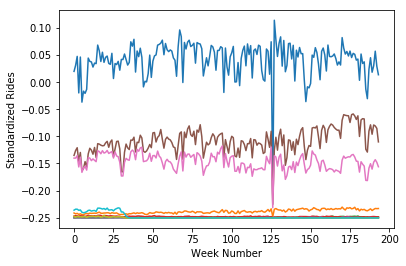

In [154]:
for i in range(10):
    pl.plot(subway_series_standard_array_plot[i])
pl.xlabel("Week Number")
pl.ylabel("Standardized Rides")

In [156]:
allfits = sm.OLS(subway_series_standard_array, weeks).fit()

ValueError: unrecognized data structures: <type 'numpy.ndarray'> / <class 'pandas.tseries.index.DatetimeIndex'>